# Coordinates in MOM6

This notebook explains the different options for coordinates in MOM6. It uses a sample restart file from the `anu-tub` configuration, and remaps onto various coordinate options using Angus' `pyale` package.

The `pyale` code is fortran-based, and pretty slow to iterate over the Adaptive Grid coordinate, so best to enable OpenMP to use multi-threading. Note that the cell below needs to be in the environment *before* OpenMP is initialised, which happens when you import the `pyale` module. Ideal is to match the number of threads with the number of cores available.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(14)

Import precompiled `pyale` code - note that you will need to match the python version here, or recompile to a newer version of python if that fails.

In [2]:
import toml
import sys
sys.path = ["/g/data/x77/ahg157/python-ale/build/lib.linux-x86_64-cpython-310"] + sys.path
import pyale

Import other standard plotting stuff.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

This is just a function to plot a transect of a given variable in the Southern half of the domain.

In [4]:
def tpplot(field,h,vlev=50,cmap=cm.cm.thermal,title=''):
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.xlim([-70.2,-25])
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.subplot(212)
    p1 = field.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(field.yh.values,h[:,ii],'m',linewidth=0.6)
        else:
            plt.plot(field.yh.values,h[:,ii],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.xlim([-70.2,-25])
    plt.ylabel('')
    plt.xlabel('Latitude')
    plt.gca().invert_yaxis()
    plt.subplots_adjust(hspace=0)
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

## Load Sample MOM6 Restart File

In [5]:
restart_filename = '/g/data/x77/amh157/anu-tub/diagnostics/INPUTS/MOM.res.nc'
ds2 = xr.open_dataset(restart_filename)
vlev = np.linspace(-2,25,28)

0.3.0


## Plot Default z* Coordinate

In [6]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_zstar.toml")
cs = pyale.mom_init_cs(params); 
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ZSTAR")

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [7]:
%%time
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs,iter=1)

CPU times: user 5.68 s, sys: 484 ms, total: 6.17 s
Wall time: 1.05 s


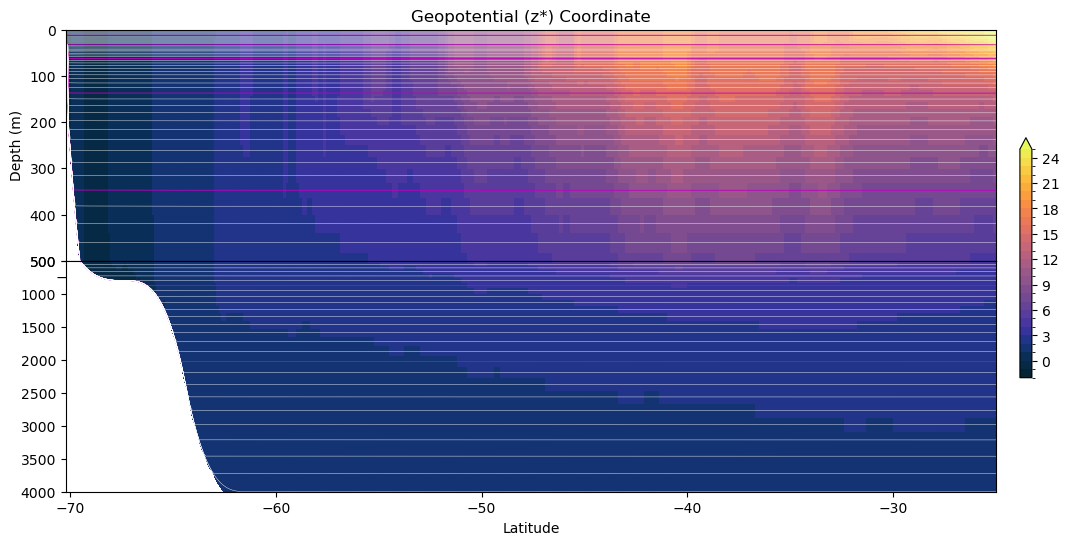

In [9]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Geopotential (z*) Coordinate')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/zstar.png',dpi=200)

In [10]:
h_depth_zstar = h_depth
temp_zstar = new_temp

## HYCOM1 Coordinate

In [10]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_hycom1.toml")
cs = pyale.mom_init_cs(params); 
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "HYCOM1")

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [11]:
%%time
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs,iter=1)

CPU times: user 7.41 s, sys: 323 ms, total: 7.73 s
Wall time: 2.81 s


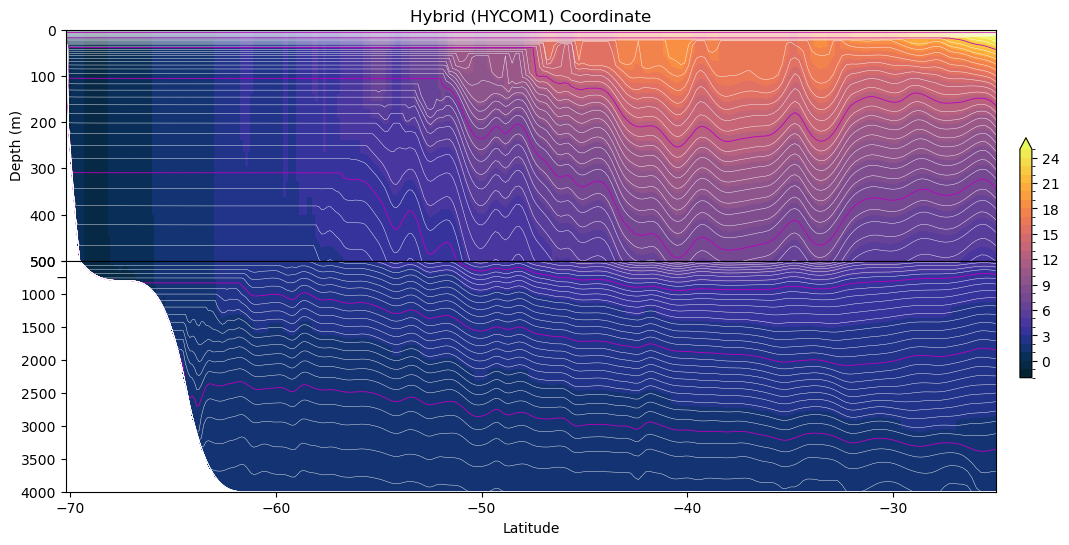

In [13]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Hybrid (HYCOM1) Coordinate')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/hycom1.png',dpi=200)

In [13]:
h_depth_hycom = h_depth
temp_hycom = new_temp

## Adaptive Grid Coordinate

In [14]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
cs = pyale.mom_init_cs(params); 
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  T
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              OCEAN_OMP_THREADS:            1
 MOM_domains                              OCEAN_OMP_HYPER_THREAD:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  T
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                         

In [15]:
%%time
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs,iter=300,dt=3600)

CPU times: user 53min 7s, sys: 2min 43s, total: 55min 50s
Wall time: 8min 40s


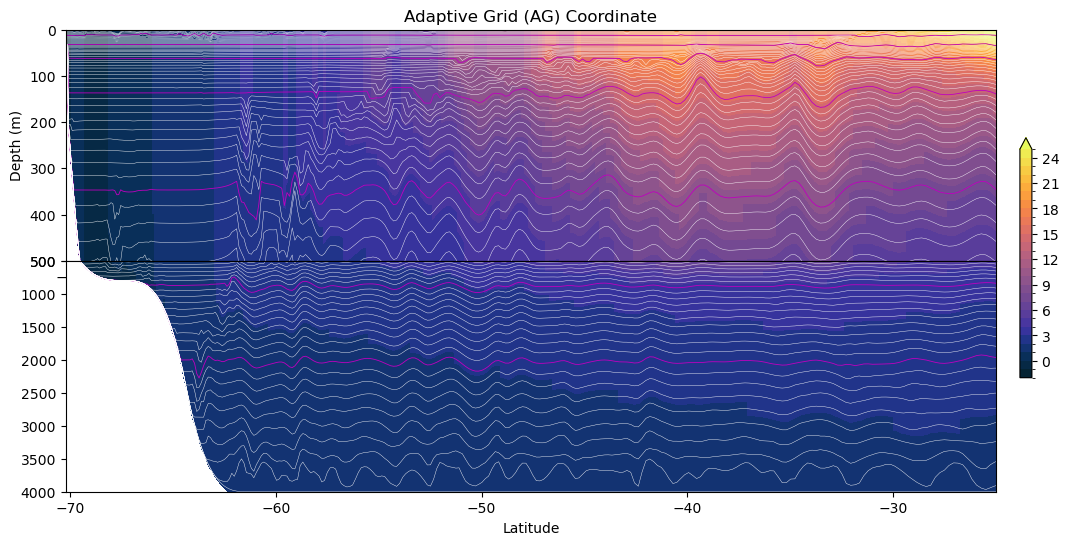

In [16]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='Adaptive Grid (AG) Coordinate')
plt.savefig('/g/data/x77/amh157/anu-tub/diagnostics/adapt.png',dpi=200)

In [17]:
h_depth_adapt = h_depth
temp_adapt = new_temp

## Terrain-following

In [ ]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_sigma.toml")
cs = pyale.mom_init_cs(params); 
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "SIGMA")

In [ ]:
%%time
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs,iter=1)

In [ ]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='SIGMA Coordinate')

In [ ]:
h_depth_sigma = h_depth
temp_sigma = new_temp

In [1]:
plt.figure(figsize=(12,6))

plt.subplot(221)
p1 = temp_zstar.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(new_temp.yh.values,h_depth_zstar[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(new_temp.yh.values,h_depth_zstar[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.xlim([-70.2,0])
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Geopote')

NameError: name 'plt' is not defined

In [ ]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal,title='HYCOM1 Coordinate')

In [ ]:
%%time
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=100, dt=3600)

In [ ]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))    
tpplot(new_temp,h_depth,vlev=vlev,cmap=cm.cm.thermal)

In [ ]:
delT = new_temp.differentiate("yh")
tpplot(delT,h_depth,cmap=cm.cm.curl)
print("mean T gradient is", np.fabs(delT).mean().values) # should really weight this by cell volume

In [17]:
!echo $OMP_NUM_THREADS

28


In [16]:
os.environ["OMP_NUM_THREADS"] = str(28)

In [15]:
import os